# Libraries

Import libraries, set random seed, define rainy threshold

In [1]:
import os

import numpy as np
import pandas as pd
from math import floor, ceil

import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import seaborn as sns

#import tensorflow as tf

print('All packages imported.')

All packages imported.


In [2]:
# Interactive iPython Notebook

#import ipywidgets as widgets
#from ipywidgets import interact, interact_manual

In [3]:
# Random seed for reproducibility

seed = 42
print(f'Random seed set as {seed}.')

Random seed set as 42.


In [5]:
# Set threshold of rainy events

prec_threshold = 0
print(f'Threshold of rainy event is {prec_threshold} mm/hr')

Threshold of rainy event is 0 mm/hr


# Data Pre-processing

Import data, clean data, inspect faulty data, visualize DataFrame

In [6]:
def get_file_path(file_name):
    CURRENT_DIR = os.getcwd()
    DATA_DIR = f'{CURRENT_DIR}/../../../data/stage-1_cleaned'
    FILE_PATH = f'{DATA_DIR}/{file_name}'
    return FILE_PATH


def import_df(FILE_PATH, index_col=None):
    df = pd.read_csv(FILE_PATH,
                     index_col=index_col)
    return df


def df_drop_col(df, cols_str):
    return df.drop(columns=cols_str)


def df_check_NaN(df, description='data'):
    if df.isnull().sum().sum() == 0:
        print(f'{description.capitalize()}: no NaN')
    else:
        raise Exception(f'There are NaN entries in {description}.')
    return None


def df_check_shape(df, description='data'):
    print(f'{description.capitalize()} dimension: {df.shape}')
    return None


def df_shuffle(df, seed=seed):
    from sklearn.utils import shuffle
    return shuffle(df, random_state=seed)


t_low, t_up = 295, 305


def check_faulty_ratio(col, low=t_low, up=t_up, description='the data'):
    ratio = ((col < low) | (col > up)).sum() / col.size
    print(f'{description.capitalize()} faulty ratio: {ratio:.2%}')
    return None


def df_rm_faulty(df, col_str='T_p1000', low=t_low, up=t_up, checks=False, description='good data'):
    good_bool = (df[col_str] >= low) & (df[col_str] <= up)
    good_data = df[good_bool]
    if checks:
        df_check_NaN(good_data, description=description)
        df_check_shape(good_data, description=description)
    return good_data

In [8]:
# Get file
file_name = 'twparmbeatmC1_CAPE_no_nan.csv' # or 'twparmbeatmC1_no_nan.csv'
FILE_PATH = get_file_path(file_name)
# Import data
data = import_df(FILE_PATH,
                 index_col=0)
# Clean data
data = df_drop_col(data, ['time'])#, 'hour', 'month'])
df_check_NaN(data)
#data = df_shuffle(data)

# Inspect proportion of 'faulty' data
check_faulty_ratio(data['T_p1000'], description='temperature @ p1000')

# Visualize data
df_check_shape(data)
data.head()

FileNotFoundError: File b'/exports/csce/datastore/geos/users/s1895566/GitHub/Machine-Learning-Climate-Parameterization/main/stage-1/code/ML/../../../data/stage-1_cleaned/merged_dropped.csv' does not exist

In [7]:
# Remove faulty data
good_data = df_rm_faulty(data,
                         col_str='T_p1000',
                         checks=True)

Good data: no NaN
Good data dimension: (3968, 156)


# Data Visualization

pair plot, correlation matrix

In [8]:
def plot_pair(df, cols_str, hue_str=None):
    sns_plot = sns.pairplot(df,
                            vars=cols_str,
                            hue=hue_str,
                            palette='bright',
                            diag_kind='kde',
                            plot_kws={'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                            height=4)
    plt.show()


def plot_corr(df, annotate=False):
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    sns_plot = sns.heatmap(corr,
                           mask=mask,
                           annot=annotate,
                           vmax=.5,
                           center=0,
                           square=True,
                           linewidths=.5,
                           cbar_kws={"shrink": .5})

    plt.title('Correlation matrix', fontsize=15)
    plt.show()

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


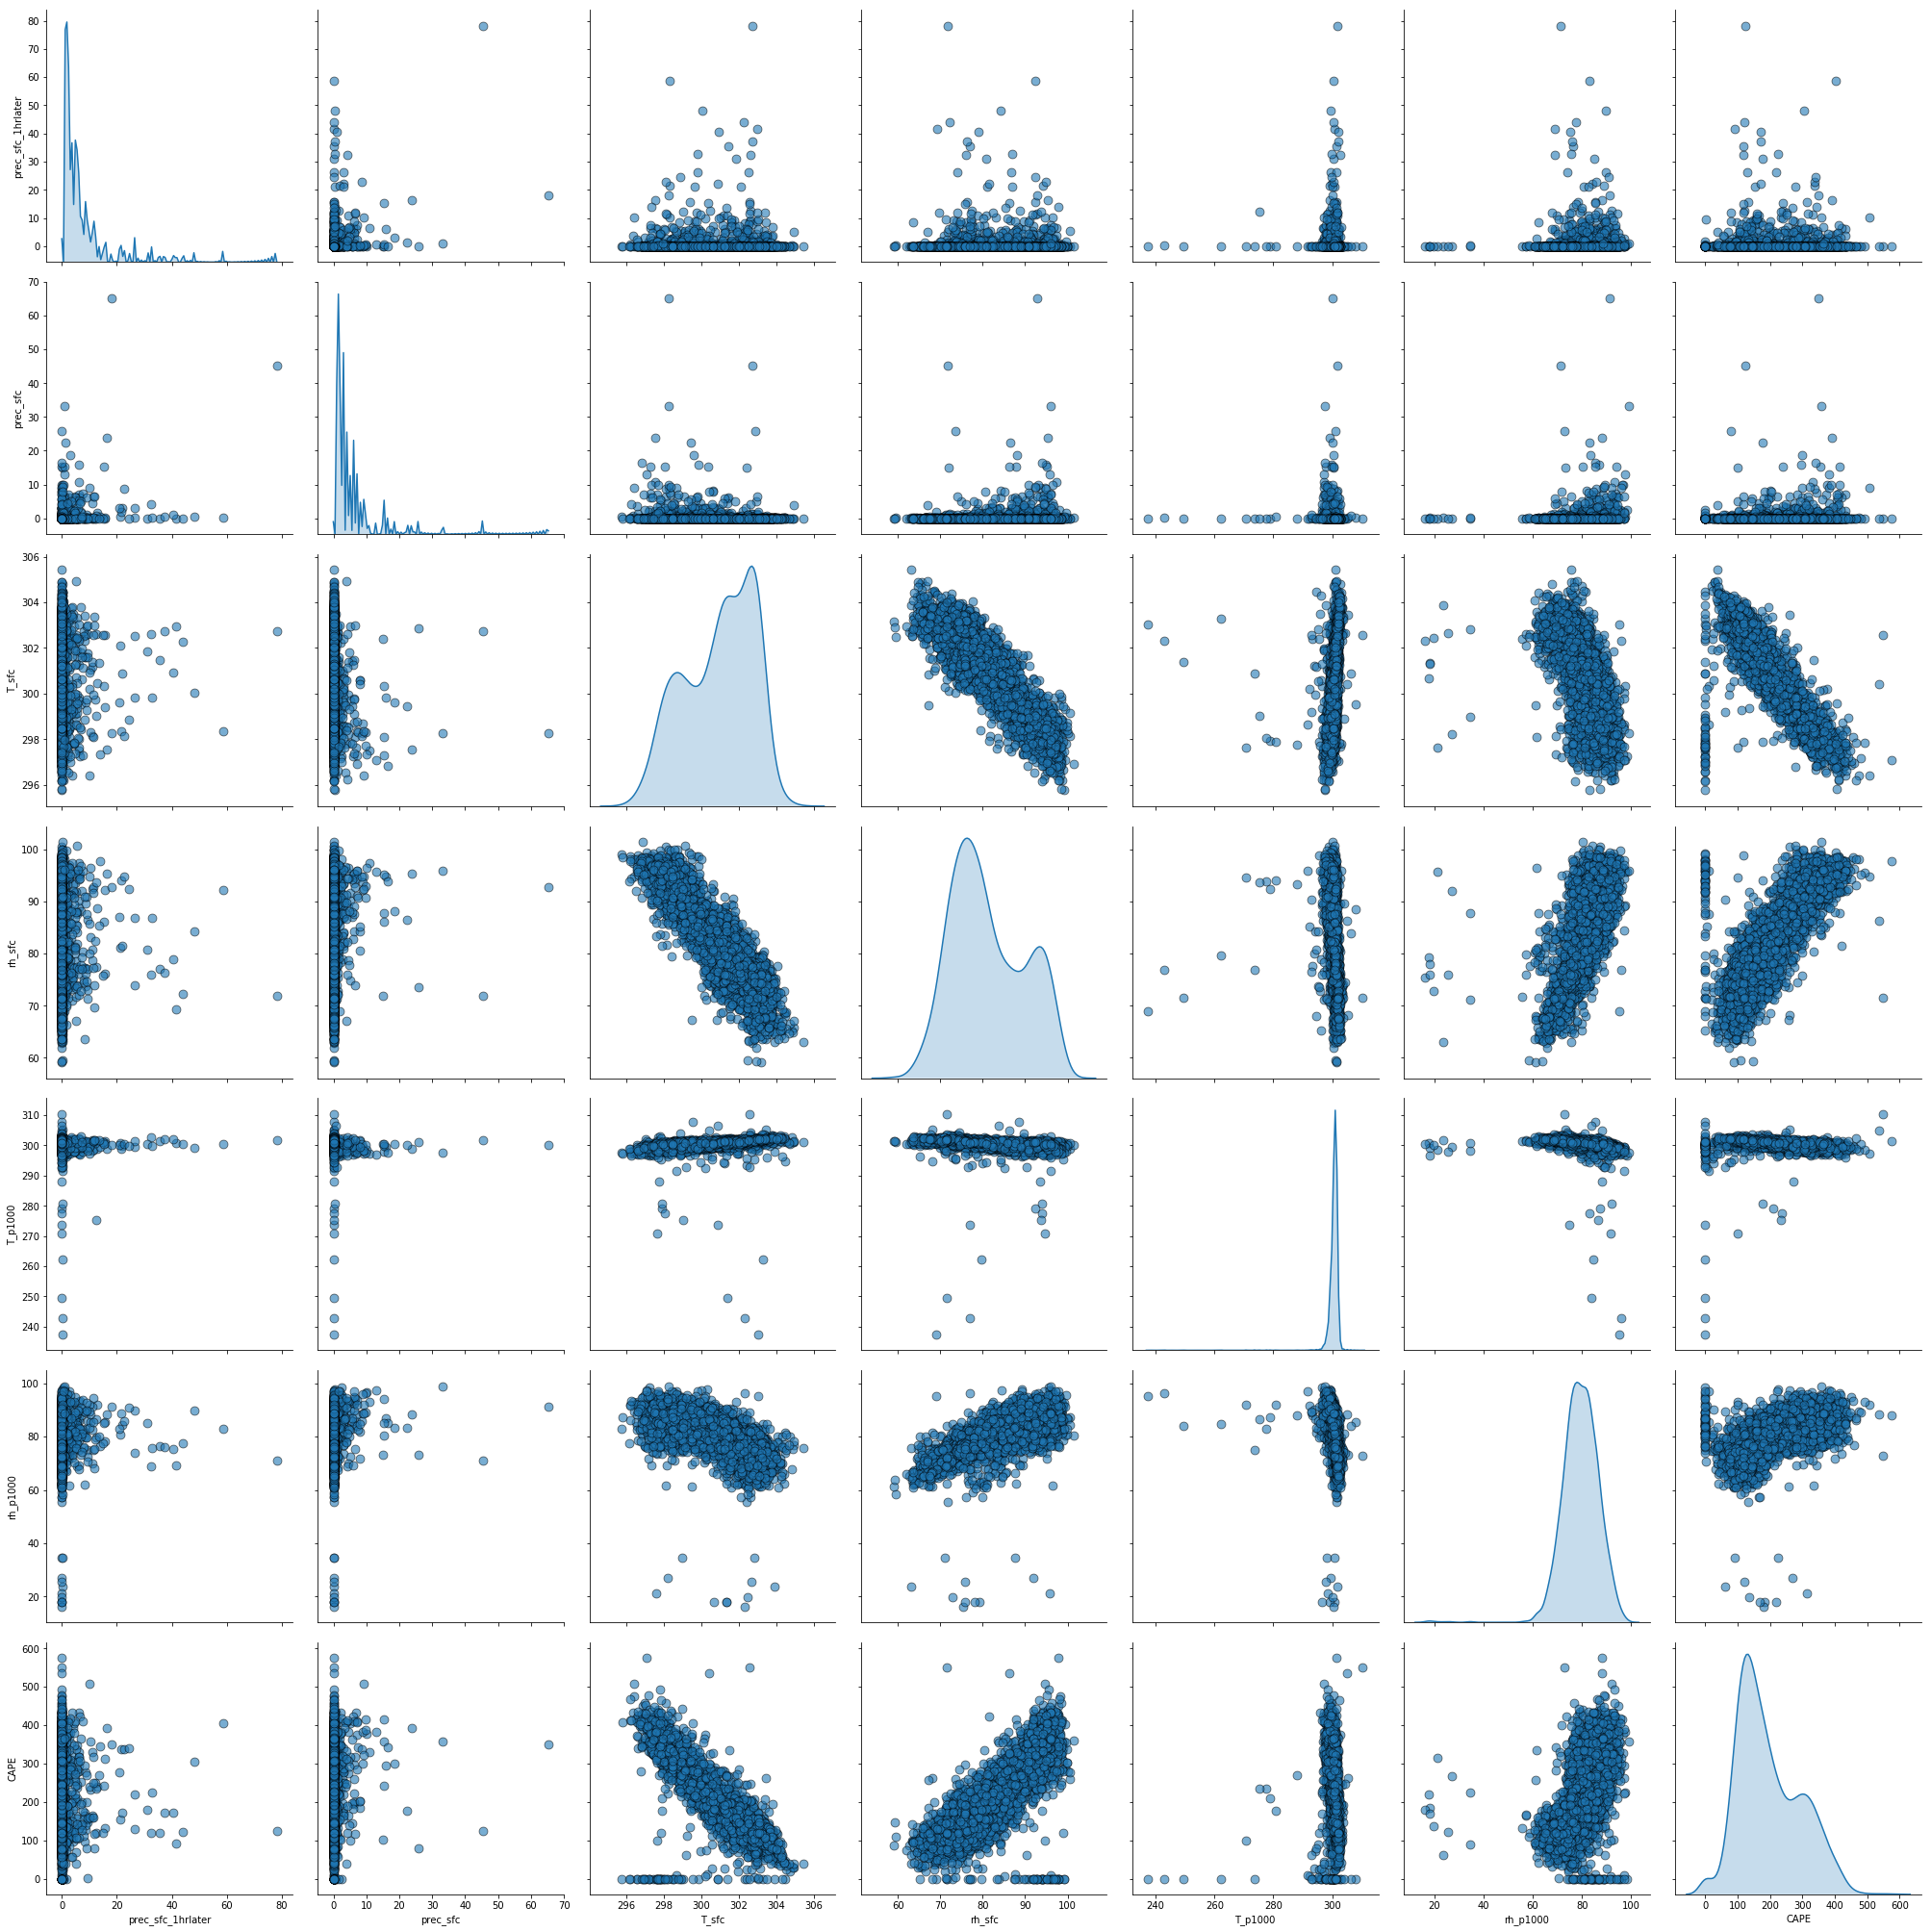

In [9]:
# Pair plot
plot_pair(data,
          cols_str=['prec_sfc_1hrlater', 'prec_sfc', 'T_sfc', 'rh_sfc', 'T_p1000', 'rh_p1000', 'CAPE'])

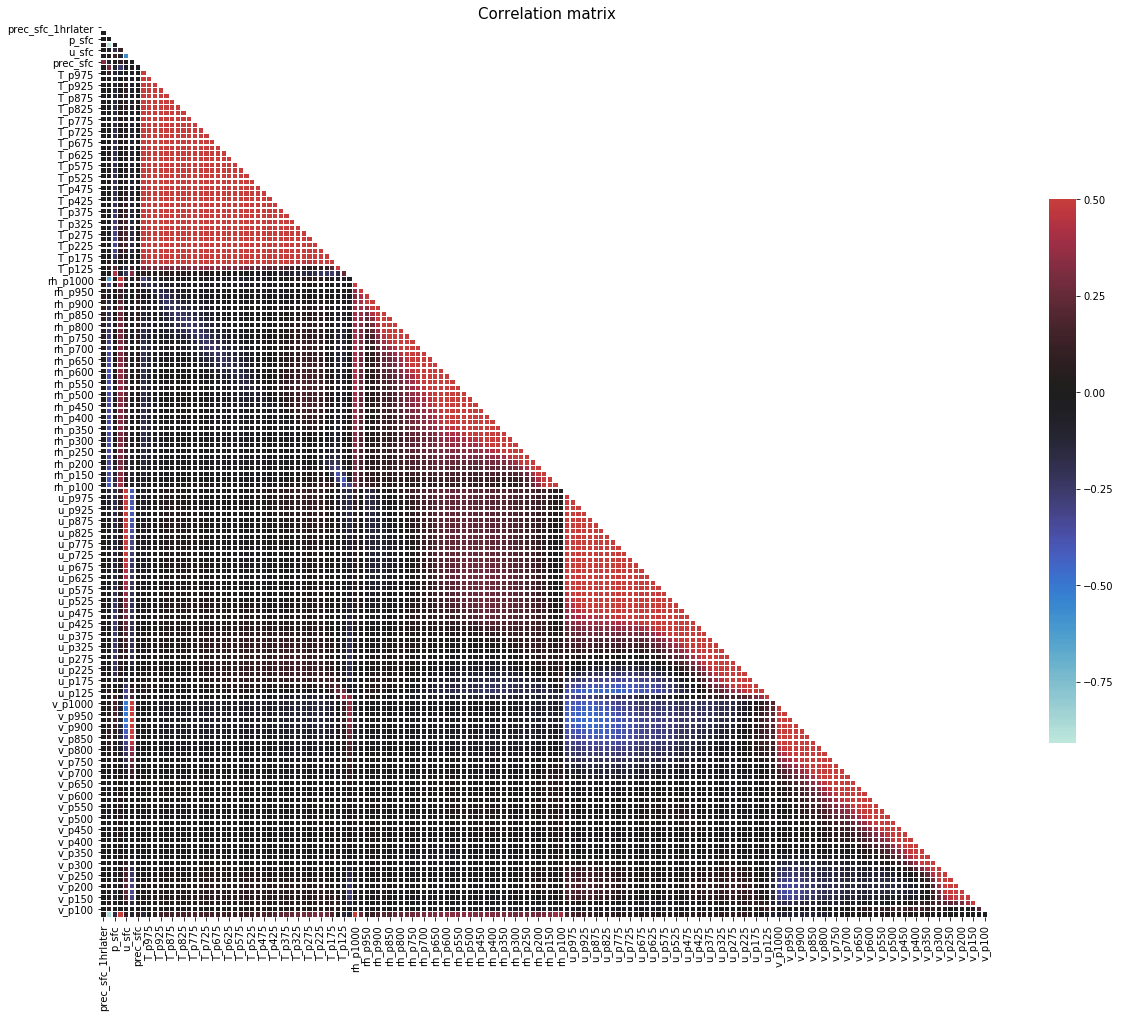

In [10]:
# Correlation Matrix
plot_corr(data)

# Data Standardization

Train-test split, convert value to binary class (y), standardize (x)

In [11]:
# Train-test split


def split(df, y_col_str, train_size=0.6, seed=seed):
    X = df_drop_col(df, y_col_str)
    Y = df[y_col_str]
    from sklearn.model_selection import train_test_split
    train_x, test_x, train_y, test_y = train_test_split(X, Y,
                                                        train_size=train_size,
                                                        random_state=seed,
                                                        shuffle=True,
                                                        stratify=None)
    return train_x, test_x, train_y, test_y


def classify(col, threshold):
    return (col > threshold) * 1


def check_bin_class_ratio(col, target=1):
    ratio = col.mean() if target else 1-col.mean()
    print(f'{target} class ratio: {ratio:.2%}')
    return None


def standardize(train_x, test_x):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler().fit(train_x)
    train_x, test_x = [scaler.transform(x) for x in [train_x, test_x]]
    return train_x, test_x

In [12]:
# Split
train_x, test_x, train_y_reg, test_y_reg = split(data, 'prec_sfc_1hrlater',
                                                 train_size=0.6)
# Class-ify
train_y, test_y = [classify(y_reg, threshold=prec_threshold)
                   for y_reg in [train_y_reg, test_y_reg]]
[check_bin_class_ratio(y, target=0) for y in [train_y, test_y]]

# Standardize
train_x, test_x = standardize(train_x, test_x)

0 class ratio: 84.51%
0 class ratio: 84.23%


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Machine Learning

In [13]:
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

all_data = (train_x, test_x, train_y, test_y)


def all_x(data):
    train_x, test_x, train_y, test_y = data
    return np.concatenate((train_x, test_x))


def all_y(data):
    train_x, test_x, train_y, test_y = data
    return np.concatenate((train_y, test_y))

## KNN

In [14]:
def KNN(data, n_neighbors, mode='cv', n_folds=5):
    train_x, test_x, train_y, test_y = data

    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    if mode == 'cv':
        acc_list = cross_val_score(knn, all_x(data), all_y(data),
                                   cv=n_folds,
                                   n_jobs=-1)
        return None, acc_list
    else:
        knn = knn.fit(train_x, train_y)
        test_y_hat = knn.predict(test_x)
        acc = accuracy_score(test_y_hat, test_y)

        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return knn, acc


def KNN_grid_search(data, n_neighbors_grid=range(1, 11)):
    n_neighbors_opt, acc_opt = 0, 0
    for k in n_neighbors_grid:
        _, acc_list = KNN(data,
                          n_neighbors=k,
                          mode='cv')
        acc_mean, acc_std = acc_list.mean(), acc_list.std()
        print(f'KNN k={k}: CV Accuracy= [{acc_mean:.4f}] + [{acc_std:.4f}]')
        if acc_mean > acc_opt:
            n_neighbors_opt, acc_opt = k, acc_mean

    knn, acc = KNN(data,
                   n_neighbors=n_neighbors_opt,
                   mode='train')
    print(f'\nKNN k={n_neighbors_opt}: Accuracy= {acc:.4f}')
    return knn, acc_opt

In [15]:
# 1. KNN
knn, knn_cv_acc = KNN_grid_search(all_data)

KNN k=1: CV Accuracy= [0.7909] + [0.0035]
KNN k=2: CV Accuracy= [0.8450] + [0.0042]
KNN k=3: CV Accuracy= [0.8300] + [0.0044]
KNN k=4: CV Accuracy= [0.8425] + [0.0019]
KNN k=5: CV Accuracy= [0.8395] + [0.0056]
KNN k=6: CV Accuracy= [0.8455] + [0.0019]
KNN k=7: CV Accuracy= [0.8445] + [0.0009]
KNN k=8: CV Accuracy= [0.8467] + [0.0024]
KNN k=9: CV Accuracy= [0.8482] + [0.0029]
KNN k=10: CV Accuracy= [0.8475] + [0.0035]
             precision    recall  f1-score   support

          0       0.85      0.99      0.91      1346
          1       0.47      0.06      0.11       252

avg / total       0.79      0.84      0.79      1598

[[1328   18]
 [ 236   16]]

KNN k=9: Accuracy= 0.8411


## Logistic Regression

In [16]:
def LogReg(data, penalty, beta, mode='cv', n_folds=5, seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression(penalty=penalty,
                                C=beta,
                                max_iter=1000)

    if mode == 'cv':
        acc_list = cross_val_score(logreg, all_x(data), all_y(data),
                                   cv=n_folds,
                                   n_jobs=-1)
        return None, acc_list
    else:
        logreg = logreg.fit(train_x, train_y)
        test_y_hat = logreg.predict(test_x)
        acc = accuracy_score(test_y_hat, test_y)

        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return logreg, acc


beta_grid = np.concatenate((np.linspace(.1, .9, 9), np.linspace(1, 10, 10)))


def LogReg_grid_search(data, penalty_grid=['l2', 'l1'], beta_grid=beta_grid):
    penalty_opt, beta_opt, acc_opt = '', 0, 0
    for penalty in penalty_grid:
        for beta in beta_grid:
            _, acc_list = LogReg(data,
                                 penalty=penalty,
                                 beta=beta,
                                 mode='cv')
            acc_mean, acc_std = acc_list.mean(), acc_list.std()
            print(
                f'{penalty.capitalize()} LogReg β={beta:.1f}: CV Accuracy= [{acc_mean:.4f}] + [{acc_std:.4f}]')
            if acc_mean > acc_opt:
                penalty_opt, beta_opt, acc_opt = penalty, beta, acc_mean

    logreg, acc = LogReg(data,
                         penalty=penalty_opt,
                         beta=beta_opt,
                         mode='train')
    print(
        f'\n{penalty_opt.capitalize()} LogReg β={beta_opt:.1f}: Accuracy= {acc:.4f}')
    return logreg, acc_opt

In [17]:
# 2. Logistic Regression
logreg, logreg_cv_acc = LogReg_grid_search(all_data)

L2 LogReg β=0.1: CV Accuracy= [0.8480] + [0.0029]
L2 LogReg β=0.2: CV Accuracy= [0.8477] + [0.0027]
L2 LogReg β=0.3: CV Accuracy= [0.8470] + [0.0022]
L2 LogReg β=0.4: CV Accuracy= [0.8470] + [0.0027]
L2 LogReg β=0.5: CV Accuracy= [0.8460] + [0.0025]
L2 LogReg β=0.6: CV Accuracy= [0.8460] + [0.0030]
L2 LogReg β=0.7: CV Accuracy= [0.8460] + [0.0025]
L2 LogReg β=0.8: CV Accuracy= [0.8457] + [0.0024]
L2 LogReg β=0.9: CV Accuracy= [0.8452] + [0.0023]
L2 LogReg β=1.0: CV Accuracy= [0.8445] + [0.0026]
L2 LogReg β=2.0: CV Accuracy= [0.8432] + [0.0030]
L2 LogReg β=3.0: CV Accuracy= [0.8427] + [0.0037]
L2 LogReg β=4.0: CV Accuracy= [0.8427] + [0.0040]
L2 LogReg β=5.0: CV Accuracy= [0.8427] + [0.0040]
L2 LogReg β=6.0: CV Accuracy= [0.8427] + [0.0040]
L2 LogReg β=7.0: CV Accuracy= [0.8430] + [0.0040]
L2 LogReg β=8.0: CV Accuracy= [0.8430] + [0.0040]
L2 LogReg β=9.0: CV Accuracy= [0.8432] + [0.0036]
L2 LogReg β=10.0: CV Accuracy= [0.8430] + [0.0036]
L1 LogReg β=0.1: CV Accuracy= [0.8482] + [0.0027]

## SVM

In [18]:
def SVM(data, beta, mode='cv', n_folds=5, seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.svm import SVC
    svm = SVC(C=beta,
              kernel='rbf',
              random_state=seed)

    if mode == 'cv':
        acc_list = cross_val_score(svm, all_x(data), all_y(data),
                                   cv=n_folds,
                                   n_jobs=-1)
        return None, acc_list
    else:
        svm = svm.fit(train_x, train_y)
        test_y_hat = svm.predict(test_x)
        acc = accuracy_score(test_y_hat, test_y)

        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return svm, acc


beta_grid = np.concatenate((np.linspace(.1, .9, 9), np.linspace(1, 10, 10)))


def SVM_grid_search(data, beta_grid=beta_grid):
    beta_opt, acc_opt = 0, 0
    for beta in beta_grid:
        _, acc_list = SVM(data,
                          beta=beta,
                          mode='cv')
        acc_mean, acc_std = acc_list.mean(), acc_list.std()
        print(
            f'SVM β={beta:.1f}: CV Accuracy= [{acc_mean:.4f}] + [{acc_std:.4f}]')
        if acc_mean > acc_opt:
            beta_opt, acc_opt = beta, acc_mean

    svm, acc = SVM(data,
                   beta=beta_opt,
                   mode='train')
    print(f'\nSVM β={beta_opt:.1f}: Accuracy= {acc:.4f}')
    return svm, acc_opt

In [19]:
# 3. SVM
svm, svm_cv_acc = SVM_grid_search(all_data)

SVM β=0.1: CV Accuracy= [0.8440] + [0.0005]
SVM β=0.2: CV Accuracy= [0.8440] + [0.0005]
SVM β=0.3: CV Accuracy= [0.8432] + [0.0013]
SVM β=0.4: CV Accuracy= [0.8457] + [0.0021]
SVM β=0.5: CV Accuracy= [0.8457] + [0.0029]
SVM β=0.6: CV Accuracy= [0.8465] + [0.0038]
SVM β=0.7: CV Accuracy= [0.8467] + [0.0034]
SVM β=0.8: CV Accuracy= [0.8482] + [0.0044]
SVM β=0.9: CV Accuracy= [0.8492] + [0.0039]
SVM β=1.0: CV Accuracy= [0.8505] + [0.0041]
SVM β=2.0: CV Accuracy= [0.8565] + [0.0064]
SVM β=3.0: CV Accuracy= [0.8593] + [0.0076]
SVM β=4.0: CV Accuracy= [0.8557] + [0.0051]
SVM β=5.0: CV Accuracy= [0.8560] + [0.0045]
SVM β=6.0: CV Accuracy= [0.8535] + [0.0055]
SVM β=7.0: CV Accuracy= [0.8492] + [0.0057]
SVM β=8.0: CV Accuracy= [0.8465] + [0.0078]
SVM β=9.0: CV Accuracy= [0.8450] + [0.0059]
SVM β=10.0: CV Accuracy= [0.8440] + [0.0075]
             precision    recall  f1-score   support

          0       0.86      0.98      0.92      1346
          1       0.64      0.16      0.26       252

av

## Random Forest

In [20]:
def RandomForest(data, depth, mode='oob', seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators=1000,
                                    max_depth=depth,
                                    oob_score=True,
                                    n_jobs=-1,
                                    random_state=seed)
    forest = forest.fit(train_x, train_y)
    test_y_hat = forest.predict(test_x)

    if mode == 'oob':
        acc_oob = forest.oob_score_
        return forest, acc_oob
    else:
        acc = accuracy_score(test_y_hat, test_y)
        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return forest, acc


beta_grid = np.concatenate((np.linspace(.1, .9, 9), np.linspace(1, 10, 10)))


def RandomForest_grid_search(data, depth_grid=range(2, 11)):
    depth_opt, acc_opt = 0, 0
    for depth in depth_grid:
        _, acc_oob = RandomForest(data,
                                  depth=depth,
                                  mode='oob')
        print(f'RandomForest depth={depth}: OOB Accuracy= [{acc_oob:.4f}]')
        if acc_oob > acc_opt:
            depth_opt, acc_opt = depth, acc_oob

    forest, acc = RandomForest(data,
                               depth=depth_opt,
                               mode='train')
    print(f'\nRandomForest depth={depth_opt}: Accuracy= {acc:.4f}')
    return forest, acc_opt

In [21]:
# 4. Random Forest
forest, forest_oob_acc = RandomForest_grid_search(all_data)

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForest depth=2: OOB Accuracy= [0.8455]
RandomForest depth=3: OOB Accuracy= [0.8480]
RandomForest depth=4: OOB Accuracy= [0.8493]
RandomForest depth=5: OOB Accuracy= [0.8534]
RandomForest depth=6: OOB Accuracy= [0.8589]
RandomForest depth=7: OOB Accuracy= [0.8630]
RandomForest depth=8: OOB Accuracy= [0.8676]
RandomForest depth=9: OOB Accuracy= [0.8681]
RandomForest depth=10: OOB Accuracy= [0.8735]
             precision    recall  f1-score   support

          0       0.87      0.99      0.93      1346
          1       0.81      0.22      0.35       252

avg / total       0.86      0.87      0.84      1598

[[1333   13]
 [ 196   56]]

RandomForest depth=10: Accuracy= 0.8692


## Bagging

In [22]:
def Bagging(data, mode='oob', seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.ensemble import BaggingClassifier
    bag = BaggingClassifier(n_estimators=1000,
                            oob_score=True,
                            n_jobs=-1,
                            random_state=seed)
    bag = bag.fit(train_x, train_y)
    test_y_hat = bag.predict(test_x)

    if mode == 'oob':
        acc_oob = bag.oob_score_
        print(f'Bagging: OOB Accuracy= [{acc_oob:.4f}]')
        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return bag, acc_oob
    else:
        acc = accuracy_score(test_y_hat, test_y)
        print(f'Bagging: Accuracy= [{acc:.4f}]')
        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return bag, acc

In [23]:
# 5. Bagging
bag, bag_oob_acc = Bagging(all_data,
                           mode='oob')

Bagging: OOB Accuracy= [0.8931]
             precision    recall  f1-score   support

          0       0.93      0.95      0.94      1346
          1       0.68      0.60      0.64       252

avg / total       0.89      0.89      0.89      1598

[[1276   70]
 [ 102  150]]


## Decision Tree

In [24]:
def DecisionTree(data, depth=None, seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(max_depth=depth,
                                  random_state=seed)
    tree = tree.fit(train_x, train_y)
    test_y_hat = tree.predict(test_x)

    acc = accuracy_score(test_y_hat, test_y)
    print(classification_report(test_y, test_y_hat))
    print(confusion_matrix(test_y, test_y_hat))
    return tree, acc

In [25]:
# 6. Decision Tree
tree, tree_acc = DecisionTree(all_data)

             precision    recall  f1-score   support

          0       0.91      0.89      0.90      1346
          1       0.48      0.54      0.51       252

avg / total       0.84      0.84      0.84      1598

[[1202  144]
 [ 117  135]]


## Extra Trees

In [26]:
def ExtraTrees(data, depth=None, mode='oob', seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.ensemble import ExtraTreesClassifier
    extra = ExtraTreesClassifier(n_estimators=1000,
                                 max_depth=depth,
                                 oob_score=mode == 'oob',
                                 bootstrap=mode == 'oob',
                                 n_jobs=-1,
                                 random_state=seed)
    extra = extra.fit(train_x, train_y)
    test_y_hat = extra.predict(test_x)

    if mode == 'oob':
        acc_oob = extra.oob_score_
        print(f'ExtraTrees: OOB Accuracy= [{acc_oob:.4f}]')
        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return extra, acc_oob
    else:
        acc = accuracy_score(test_y_hat, test_y)
        print(f'ExtraTrees: Accuracy= [{acc:.4f}]')
        print(classification_report(test_y, test_y_hat))
        print(confusion_matrix(test_y, test_y_hat))
        return extra, acc

In [27]:
# 7. Extra Trees
extra, extra_oob_acc = ExtraTrees(all_data,
                                  mode='train')

ExtraTrees: Accuracy= [0.8486]
             precision    recall  f1-score   support

          0       0.85      0.99      0.92      1346
          1       0.67      0.08      0.14       252

avg / total       0.82      0.85      0.79      1598

[[1336   10]
 [ 232   20]]


## Gradient Boosting

In [28]:
def GradB(data, seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.ensemble import GradientBoostingClassifier
    gradb = GradientBoostingClassifier(n_estimators=1000,
                                       random_state=seed)
    gradb = gradb.fit(train_x, train_y)
    test_y_hat = gradb.predict(test_x)

    acc = accuracy_score(test_y_hat, test_y)
    print(f'Gradient Boosting: Accuracy= [{acc:.4f}]')
    print(classification_report(test_y, test_y_hat))
    print(confusion_matrix(test_y, test_y_hat))
    return gradb, acc

In [29]:
# 8. Gradient Boosting
gradb, gradb_acc = GradB(all_data)

Gradient Boosting: Accuracy= [0.8942]
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      1346
          1       0.71      0.56      0.63       252

avg / total       0.89      0.89      0.89      1598

[[1288   58]
 [ 111  141]]


## AdaBoost

In [30]:
def AdaB(data, seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.ensemble import AdaBoostClassifier
    adab = AdaBoostClassifier(n_estimators=1000,
                              random_state=seed)
    adab = adab.fit(train_x, train_y)
    test_y_hat = adab.predict(test_x)

    acc = accuracy_score(test_y_hat, test_y)
    print(f'AdaBoost: Accuracy= [{acc:.4f}]')
    print(classification_report(test_y, test_y_hat))
    print(confusion_matrix(test_y, test_y_hat))
    return adab, acc

In [31]:
# 9. AdaBoost
adab, adab_acc = AdaB(all_data)

AdaBoost: Accuracy= [0.8680]
             precision    recall  f1-score   support

          0       0.91      0.94      0.92      1346
          1       0.60      0.51      0.55       252

avg / total       0.86      0.87      0.86      1598

[[1259   87]
 [ 124  128]]


## XGBoost

In [32]:
def XGB(data, seed=seed):
    train_x, test_x, train_y, test_y = data

    from xgboost import XGBClassifier
    xgb = XGBClassifier(random_state=seed)
    xgb = xgb.fit(train_x, train_y)
    test_y_hat = xgb.predict(test_x)

    acc = accuracy_score(test_y_hat, test_y)
    print(f'XGBoosting: Accuracy= [{acc:.4f}]')
    print(classification_report(test_y, test_y_hat))
    print(confusion_matrix(test_y, test_y_hat))
    return xgb, acc

In [33]:
# 10. XGBoost
xgb, xgb_acc = XGB(all_data)

XGBoosting: Accuracy= [0.8961]
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      1346
          1       0.72      0.55      0.63       252

avg / total       0.89      0.90      0.89      1598

[[1293   53]
 [ 113  139]]


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Naïve Bayes

In [34]:
def NBayes(data, priors=None):
    train_x, test_x, train_y, test_y = data

    from sklearn.naive_bayes import GaussianNB
    bayes = GaussianNB(priors=priors)
    bayes = bayes.fit(train_x, train_y)
    test_y_hat = bayes.predict(test_x)

    acc = accuracy_score(test_y_hat, test_y)
    print(f'Naïve Bayes: Accuracy= [{acc:.4f}]')
    print(classification_report(test_y, test_y_hat))
    print(confusion_matrix(test_y, test_y_hat))
    return bayes, acc

In [35]:
# 11. Naïve Bayes
bayes, bayes_acc = NBayes(all_data)

Naïve Bayes: Accuracy= [0.8217]
             precision    recall  f1-score   support

          0       0.87      0.93      0.90      1346
          1       0.39      0.24      0.30       252

avg / total       0.79      0.82      0.80      1598

[[1252   94]
 [ 191   61]]


## Gaussian Process

In [36]:
def GP(data, seed=seed):
    train_x, test_x, train_y, test_y = data

    from sklearn.gaussian_process import GaussianProcessClassifier
    gp = GaussianProcessClassifier(n_jobs=-1,
                                   random_state=seed)
    gp = gp.fit(train_x, train_y)
    test_y_hat = gp.predict(test_x)

    acc = accuracy_score(test_y_hat, test_y)
    print(f'Gaussian Process: Accuracy= [{acc:.4f}]')
    print(classification_report(test_y, test_y_hat))
    print(confusion_matrix(test_y, test_y_hat))
    return gp, acc

In [37]:
# 12. Gaussian Process
gp, gp_acc = GP(all_data)

Gaussian Process: Accuracy= [0.7979]
             precision    recall  f1-score   support

          0       0.87      0.89      0.88      1346
          1       0.35      0.32      0.33       252

avg / total       0.79      0.80      0.79      1598

[[1194  152]
 [ 171   81]]


# Ensemble Learning

## Voting

In [38]:
def Voting(data, models, model_name, weights='None', how_to_vote='hard'):
    train_x, test_x, train_y, test_y = data
    model_zip = list(zip(model_name, models))

    from sklearn.ensemble import VotingClassifier
    vote = VotingClassifier(estimators=model_zip,
                            voting=how_to_vote,
                            weights=weights,
                            n_jobs=-1)
    vote = vote.fit(train_x, train_y)
    test_y_hat = vote.predict(test_x)

    acc = accuracy_score(test_y_hat, test_y)
    print(f'{how_to_vote.capitalize()} voting: Accuracy= [{acc:.4f}]')
    print(classification_report(test_y, test_y_hat))
    print(confusion_matrix(test_y, test_y_hat))
    return vote, acc

In [39]:
models = [knn, logreg, svm, forest, bag,
          tree, extra, gradb, adab, xgb, bayes, gp]

model_name = ['KNN', 'Logistic Regression', 'SVM', 'Random Forest', 'Bagging', 'Decision Tree',
              'Extra Trees', 'Gradient Boosting', 'AdaBoosting', 'XGBoosting', 'Naïve Bayes', 'Gaussian Process']

model_acc = [knn_cv_acc, logreg_cv_acc, svm_cv_acc, forest_oob_acc, bag_oob_acc,
             tree_acc, extra_oob_acc, gradb_acc, adab_acc, xgb_acc, bayes_acc, gp_acc]

model_summary = pd.DataFrame({'Model': model_name,
                              'Accuracy': model_acc}).set_index('Model').sort_values('Accuracy',
                                                                                     ascending=False)
model_summary

,Accuracy
Model,
XGBoosting,0.896120
Gradient Boosting,0.894243
Bagging,0.893111
Random Forest,0.873486
AdaBoosting,0.867960
SVM,0.859252
Logistic Regression,0.849236
Extra Trees,0.848561
KNN,0.848236


In [40]:
# ∞. Voting
vote, vote_acc = Voting(all_data, models, model_name, weights=model_acc)

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Hard voting: Accuracy= [0.8786]
             precision    recall  f1-score   support

          0       0.89      0.98      0.93      1346
          1       0.78      0.32      0.46       252

avg / total       0.87      0.88      0.86      1598

[[1323   23]
 [ 171   81]]


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Stacking

In [41]:
def Stacking(data, models, seed=seed):
    train_x, test_x, train_y, test_y = data

    from vecstack import stacking
    train_S, test_S = stacking(models,
                               train_x, train_y, test_x,
                               regression=False,
                               mode='oof_pred_bag',
                               needs_proba=False,
                               save_dir=None,
                               metric=accuracy_score,
                               n_folds=5,
                               stratified=False,
                               shuffle=False,
                               random_state=seed,
                               verbose=2)
    train_S, test_S = standardize(train_S, test_S)
    return train_S, test_S

def Two_Level_Stacking(data, models, seed=seed):
    train_S, test_S = Stacking(data, models, seed=seed)
    S_data = [train_S, test_S, train_y, test_y]
    second_lev_classifier, stacking_acc = RandomForest_grid_search(S_data)
    return second_lev_classifier, stacking_acc

In [42]:
# Stacking
_, stacking_acc = Two_Level_Stacking(all_data, models)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [12]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.82881002]
    fold  1:  [0.85177453]
    fold  2:  [0.86638831]
    fold  3:  [0.83089770]
    fold  4:  [0.85803758]
    ----
    MEAN:     [0.84718163] + [0.01490319]
    FULL:     [0.84718163]

model  1:     [LogisticRegression]
    fold  0:  [0.83716075]
    fold  1:  [0.85386221]
    fold  2:  [0.86638831]
    fold  3:  [0.83924843]
    fold  4:  [0.86638831]
    ----
    MEAN:     [0.85260960] + [0.01263695]
    FULL:     [0.85260960]

model  2:     [SVC]
    fold  0:  [0.83507307]
    fold  1:  [0.85803758]
    fold  2:  [0.87682672]
    fold  3:  [0.84342380]
    fold  4:  [0.86221294]
    ----
    MEAN:     [0.85511482] + [0.01461974]
    FULL:     [0.85511482]

model  3:     [RandomForestClassifier]
    fold  0:  [0.86012526]
    fold  1:  [0.86638831]
    fold  2:  [0.88935282]
    fold  3:  [0.

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  0:  [0.88100209]


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  1:  [0.89352818]


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  2:  [0.89352818]


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  3:  [0.91231733]


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    fold  4:  [0.89352818]
    ----
    MEAN:     [0.89478079] + [0.01002088]
    FULL:     [0.89478079]

model 10:     [GaussianNB]
    fold  0:  [0.51356994]
    fold  1:  [0.83507307]
    fold  2:  [0.84342380]
    fold  3:  [0.82463466]
    fold  4:  [0.83089770]
    ----
    MEAN:     [0.76951983] + [0.12812046]
    FULL:     [0.76951983]

model 11:     [GaussianProcessClassifier]
    fold  0:  [0.79123173]
    fold  1:  [0.80793319]
    fold  2:  [0.79540710]
    fold  3:  [0.74112735]
    fold  4:  [0.79958246]
    ----
    MEAN:     [0.78705637] + [0.02361943]
    FULL:     [0.78705637]



/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


RandomForest depth=2: OOB Accuracy= [0.8952]
RandomForest depth=3: OOB Accuracy= [0.8960]
RandomForest depth=4: OOB Accuracy= [0.8952]
RandomForest depth=5: OOB Accuracy= [0.8952]
RandomForest depth=6: OOB Accuracy= [0.8923]
RandomForest depth=7: OOB Accuracy= [0.8927]
RandomForest depth=8: OOB Accuracy= [0.8910]
RandomForest depth=9: OOB Accuracy= [0.8898]
RandomForest depth=10: OOB Accuracy= [0.8906]
             precision    recall  f1-score   support

          0       0.92      0.96      0.94      1346
          1       0.70      0.56      0.63       252

avg / total       0.89      0.89      0.89      1598

[[1286   60]
 [ 110  142]]

RandomForest depth=3: Accuracy= 0.8936


# Dimensionality Reduction

## PCA

In [43]:
def two_component_PCA(x_pc, y):
    sns_plot = sns.scatterplot(x_pc['pc_1'], x_pc['pc_2'],
                               hue=y)
    plt.show()
    return None


def PCA(data, n_components=None, seed=seed):
    X, Y = all_x(data), all_y(data)
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components,
              random_state=seed)
    pca = pca.fit(X)
    X_pc = pca.transform(X)
    
    n_components = min(X.shape[0], X.shape[1]) if n_components == None else n_components
    col_name = [f'pc_{i}' for i in range(1,n_components+1)]
    # return X_pc in DataFrame
    X_pc = pd.DataFrame(X_pc, columns=col_name)
    two_component_PCA(X_pc, Y) 
    
    return pca, pca.explained_variance_ratio_, X_pc, Y

def reduce_dim(X_pc, pca_sigma_ratio, explained_var_ratio=0.9):
    pc_bool = pca_sigma_ratio.cumsum() <= 0.9
    print(f'First {pc_bool.sum()} out of {pc_bool.size} explain {explained_var_ratio:.0%} of the data.')
    return X_pc.iloc[:,0:pc_bool.sum()]

def group(df, col, col_name):
    df[col_name] = col
    return df

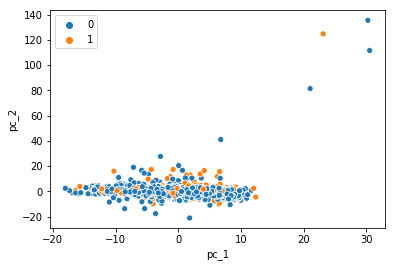

In [44]:
pca, pca_var_ratio, x_pc, y = PCA(all_data)

In [45]:
# Associate a DataFrame
data_pc = reduce_dim(x_pc, pca_var_ratio)
data_pc = group(data_pc, col=y, col_name='y')

# Split
train_x_pc, test_x_pc, train_y_pc, test_y_pc = split(data_pc, 'y',
                                                     train_size=0.6)

# Standardize
train_x_pc, test_x_pc = standardize(train_x_pc, test_x_pc)

# Associate
all_data_pc = (train_x_pc, test_x_pc, train_y_pc, test_y_pc)

First 29 out of 155 explain 90% of the data.


/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Stacking Ensemble

In [46]:
def run_all(data):
    knn, knn_cv_acc = KNN_grid_search(data)
    logreg, logreg_cv_acc = LogReg_grid_search(data)
    svm, svm_cv_acc = SVM_grid_search(data)
    forest, forest_oob_acc = RandomForest_grid_search(data)
    bag, bag_oob_acc = Bagging(data,
                               mode='oob')
    tree, tree_acc = DecisionTree(data)
    extra, extra_oob_acc = ExtraTrees(all_data,
                                      mode='train')
    gradb, gradb_acc = GradB(data)
    adab, adab_acc = AdaB(data)
    xgb, xgb_acc = XGB(data)
    bayes, bayes_acc = NBayes(data)
    gp, gp_acc = GP(data)

    models = [knn, logreg, svm, forest, bag,
              tree, extra, gradb, adab, xgb, bayes, gp]
    model_name = ['KNN', 'Logistic Regression', 'SVM', 'Random Forest', 'Bagging', 'Decision Tree',
                  'Extra Trees', 'Gradient Boosting', 'AdaBoosting', 'XGBoosting', 'Naïve Bayes', 'Gaussian Process']
    model_acc = [knn_cv_acc, logreg_cv_acc, svm_cv_acc, forest_oob_acc, bag_oob_acc,
                 tree_acc, extra_oob_acc, gradb_acc, adab_acc, xgb_acc, bayes_acc, gp_acc]
    model_summary = pd.DataFrame({'Model': model_name,
                                  'Accuracy': model_acc}).set_index('Model').sort_values('Accuracy',
                                                                                         ascending=False)
    return models, model_acc, model_name, model_summary

In [47]:
models, model_acc, model_name, model_summary = run_all(all_data_pc)
model_summary

KNN k=1: CV Accuracy= [0.7779] + [0.0142]
KNN k=2: CV Accuracy= [0.8420] + [0.0048]
KNN k=3: CV Accuracy= [0.8295] + [0.0076]
KNN k=4: CV Accuracy= [0.8457] + [0.0061]
KNN k=5: CV Accuracy= [0.8402] + [0.0066]
KNN k=6: CV Accuracy= [0.8425] + [0.0048]
KNN k=7: CV Accuracy= [0.8400] + [0.0053]
KNN k=8: CV Accuracy= [0.8457] + [0.0050]
KNN k=9: CV Accuracy= [0.8452] + [0.0065]
KNN k=10: CV Accuracy= [0.8442] + [0.0046]
             precision    recall  f1-score   support

          0       0.86      0.99      0.92      1359
          1       0.47      0.06      0.10       239

avg / total       0.80      0.85      0.80      1598

[[1343   16]
 [ 225   14]]

KNN k=4: Accuracy= 0.8492
L2 LogReg β=0.1: CV Accuracy= [0.8505] + [0.0030]
L2 LogReg β=0.2: CV Accuracy= [0.8502] + [0.0026]
L2 LogReg β=0.3: CV Accuracy= [0.8507] + [0.0026]
L2 LogReg β=0.4: CV Accuracy= [0.8507] + [0.0026]
L2 LogReg β=0.5: CV Accuracy= [0.8507] + [0.0026]
L2 LogReg β=0.6: CV Accuracy= [0.8507] + [0.0026]
L2 LogReg 

/scratch/s1895566/miniconda/base/envs/venv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBoosting: Accuracy= [0.8605]
             precision    recall  f1-score   support

          0       0.86      0.99      0.92      1359
          1       0.71      0.11      0.19       239

avg / total       0.84      0.86      0.81      1598

[[1348   11]
 [ 212   27]]
Naïve Bayes: Accuracy= [0.8542]
             precision    recall  f1-score   support

          0       0.87      0.98      0.92      1359
          1       0.55      0.14      0.22       239

avg / total       0.82      0.85      0.82      1598

[[1332   27]
 [ 206   33]]
Gaussian Process: Accuracy= [0.8385]
             precision    recall  f1-score   support

          0       0.87      0.95      0.91      1359
          1       0.41      0.19      0.26       239

avg / total       0.80      0.84      0.81      1598

[[1294   65]
 [ 193   46]]


,Accuracy
Model,
XGBoosting,0.860451
Gradient Boosting,0.857322
SVM,0.855499
Naïve Bayes,0.854193
Logistic Regression,0.850738
Extra Trees,0.848561
Bagging,0.847182
KNN,0.845734
Random Forest,0.843424
